### Test mapping

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import mudata
import anndata
import scanpy as sc
import pandas as pd
import numpy as np

from typing import List, Dict, Union

In [60]:
import multi_view_atlas as mva

In [61]:
adata = mva.utils.sample_dataset()
view_assign = adata.obsm['view_assign'].copy()
adata_dict = {}
adata_dict['full'] = adata.copy()
for v in view_assign:
    adata_dict[v] = adata[view_assign[v] == 1].copy()
mdata = mudata.MuData(adata_dict)
mvatlas = mva.tl.MultiViewAtlas(mdata, transition_rule='louvain')
assert [k.endswith('lymphoid') for k in mvatlas.mdata['lymphoid'].obsm.keys()]

In [62]:
mvatlas.get_view_pairs()

,depth,parent_view,child_view,transition_rule
0,0,full,myeloid,louvain
1,0,full,lymphoid,louvain
2,1,lymphoid,NKT cells,louvain
5,1,lymphoid,B cells,louvain
3,2,NKT cells,T cells,louvain


In [90]:
from multi_view_atlas.tl import MultiViewAtlas
from multi_view_atlas.tl.map_query import add_query
from multi_view_atlas.utils import sample_dataset

In [91]:
adata = sample_dataset()
# split in query and atlas
query_cells = np.random.choice(adata.obs_names, size=int(np.round(adata.n_obs * 0.1)), replace=False)
adata_query = adata[query_cells].copy()
adata = adata[~adata.obs_names.isin(query_cells)].copy()
print(adata)
mva1 = MultiViewAtlas(adata, subset_obsm=True, transition_rule="X_pca")
# print(adata)
# mva2 = MultiViewAtlas(adata, subset_obsm=True, transition_rule="X_pca")


AnnData object with n_obs × n_vars = 2374 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'view_hierarchy'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'view_assign'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


In [92]:
mva1['full']

AnnData object with n_obs × n_vars = 2374 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'view_hierarchy'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'view_assign'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [83]:
mva2['full']

AnnData object with n_obs × n_vars = 2374 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'view_hierarchy'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'view_assign'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:

# New embedding for NKT view
v = "NKT cells"
vadata = mva[v]
vadata.obsm[f"X_pca_{v}"] = vadata.obsm["X_pca"].copy()
mva.mdata[v].obsm = vadata.obsm.copy()

MultiViewAtlas object with view hierarchy:
	full:
	  lymphoid:
	    B cells: null
	    NKT cells:
	      T cells: null
	  myeloid: null
	
MuData object with n_obs × n_vars = 2374 × 1838
  obs:	'n_genes', 'percent_mito', 'n_counts', 'louvain'
  obsm:	'view_assign'
  6 modalities
    full:	2374 x 1838
      obs:	'n_genes', 'percent_mito', 'n_counts', 'louvain'
      var:	'n_cells'
      uns:	'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'view_hierarchy'
      obsm:	'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'view_assign'
      varm:	'PCs'
      obsp:	'distances', 'connectivities'
    myeloid:	616 x 0
      obs:	'n_genes', 'percent_mito', 'n_counts', 'louvain'
      obsm:	'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'view_assign'
      obsp:	'distances', 'connectivities'
    lymphoid:	1758 x 0
      obs:	'n_genes', 'percent_mito', 'n_counts', 'louvain'
      obsm:	'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'view_assign'
      obsp:	'dista

In [49]:
assert [k.endswith('lymphoid') for k in mvatlas.mdata['lymphoid'].obsm.keys()]

### Load dataset

In [4]:

datadir = '/nfs/team205/ed6/data/Fetal_immune/cellxgene_h5ad_files/scRNA_data/'
h5ad_files = [f for f in os.listdir(datadir) if f.endswith('embedding.h5ad')]

In [5]:
adata_full = sc.read_h5ad(os.path.join(datadir, 'PAN.A01.v01.raw_count.20210429.NKT.embedding.h5ad'), backed=False)

In [6]:
sc.pp.subsample(adata_full, 0.25, copy=False)

In [7]:
## Split in reference and query
query_cells = np.random.choice(adata_full.obs_names, size=int(np.round(adata_full.n_obs*0.1)), replace=False)
adata_query = adata_full[query_cells].copy()
adata_full = adata_full[~adata_full.obs_names.isin(query_cells)].copy()

In [8]:
assert adata_full.obs_names.isin(adata_query.obs_names).sum() == 0

In [9]:
### Split by organ
assign_dict = {
    'hematopoietic_tissue':['BM', "LI", "YS"],
    'lymphoid_tissue':['TH', "MLN", "SP"],
    'peripheral_tissue':['SK', "GU", 'KI']
}
annotation_col = 'organ'

assign_tab = np.vstack([np.where(adata_full.obs[annotation_col].isin(assign_dict[k]), 1, 0) for k in assign_dict.keys()]).T
assign_tab = pd.DataFrame(assign_tab, columns = assign_dict.keys(), index = adata_full.obs_names)

## Make dictionary of parent-child structure of views
view_hierarchy = { 'full':{
    'lymphoid_tissue':None,
    'hematopoietic_tissue':None,
    'peripheral_tissue':None
    }
}

In [10]:
import multi_view_atlas as mva

In [11]:
import traceback
adata_full.obsm['view_assign'] = assign_tab.copy()
adata_full.uns['view_hierarchy'] = view_hierarchy.copy()
# try:
mvatlas = mva.tl.MultiViewAtlas(adata_full, transition_rule='organ') 
# except:
#     v = traceback.format_exc()

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/mudata/_core/mudata.py:569: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/mudata/_core/mudata.py:569: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


### Update atlas

In [12]:
### Split by age in hematopoietic tissue
transition_rule = 'age'
parent_view = 'hematopoietic_tissue'

assign_tab = np.vstack([
    np.where(mvatlas.mdata[parent_view].obs[transition_rule] < 10, 1, 0),
    np.where(mvatlas.mdata[parent_view].obs[transition_rule] >= 10, 1, 0)
    ]).T
assign_tab = pd.DataFrame(
    assign_tab, 
    columns = ['first_trimester', 'second_trimester'], 
    index = mvatlas.mdata[parent_view].obs_names)


In [13]:
mvatlas.update_views(parent_view=parent_view, child_assign_tab=assign_tab, transition_rule=transition_rule)

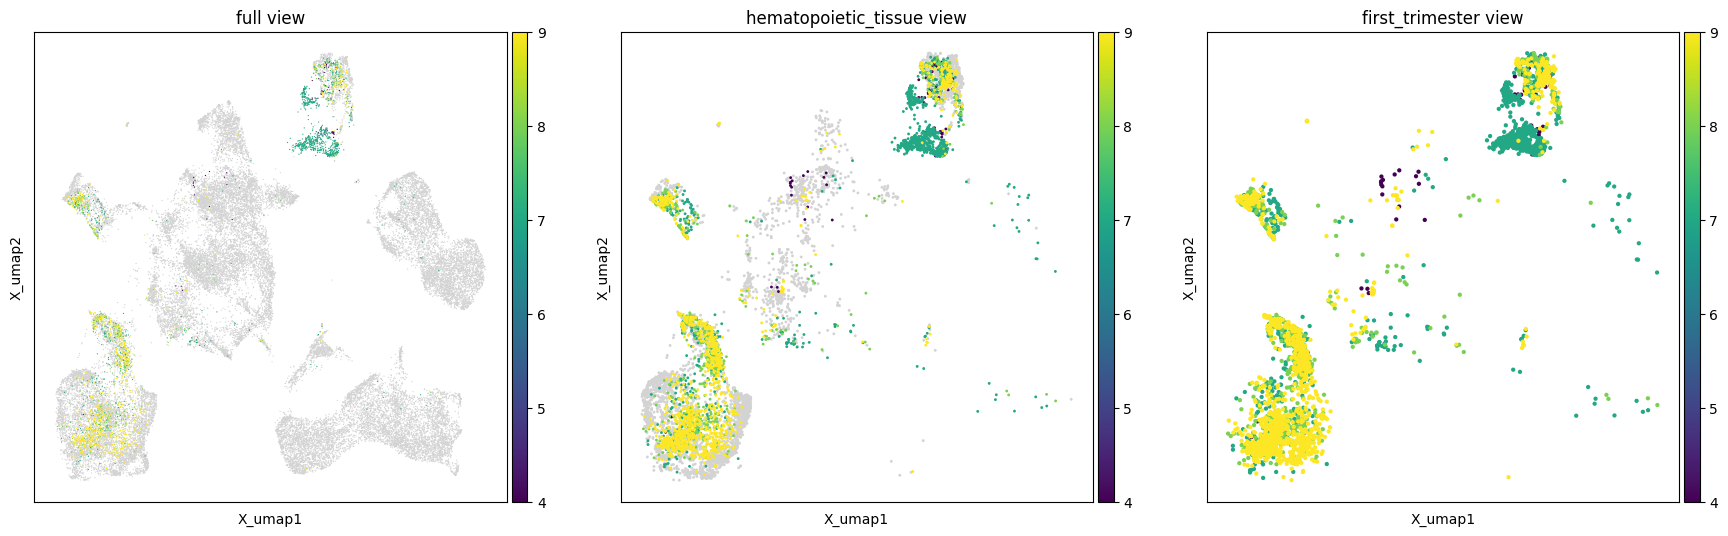

In [14]:
mva.pl.multiview_embedding(mvatlas.mdata, view='first_trimester', color='age')

### Test mapping query cells

In [35]:
from multi_view_atlas.utils import *
import multi_view_atlas as mva

In [36]:
## Map first depth level (by organ) 
if 'age' in adata_query.obs:
    age_obs = adata_query.obs['age'].copy()
    adata_query.obs.drop('age', 1, inplace=True)
mvatlas_mapped = mva.tl.add_query(mvatlas, adata_query)

Assigning to lymphoid_tissue from full
Transition rule: organ


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)


Assigning to hematopoietic_tissue from full
Transition rule: organ


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)


Assigning to peripheral_tissue from full
Transition rule: organ


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)


Assigning to first_trimester from hematopoietic_tissue
Transition rule: age
Assigning to second_trimester from hematopoietic_tissue
Transition rule: age


In [37]:
mvatlas.mdata

MuData object with n_obs × n_vars = 39209 × 33538
  obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
  obsm:	'view_assign'
  6 modalities
    full:	39209 x 33538
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'view_color'
      var:	'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
      uns:	'leiden', 'scvi', 'umap', 'view_hierarchy'
      obsm:	'X_scvi', 'X_umap', 'view_assign'
      obsp:	'scvi_connectivities', 'scvi_distances'
    lymphoid_tissue:	27537 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
      obsm:	'X_scvi', 'X_umap', 'view_assign'
      obsp:	'scvi_connectivities', 'scvi_distances'
    hematopoietic_tissue:	7195 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'view_color'
      obsm:	'X_scvi', 'X_umap', 'view_assign'
      obsp:	'scvi_connectivities', 'scvi_distances'
    peripheral_tissue:	4477 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
      obsm:	'X_scvi', 'X_umap', 'view_assign'
      obsp:	'scvi_connectivities', 'scvi_distances'
    first_trimester:	3163 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
      obsm:	'X_scvi', 'X_umap', 'view_assign'
      obsp:	'scvi_connectivities', 'scvi_distances'
    second_trimester:	4032 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
      obsm:	'X_scvi', 'X_umap', 'view_assign'
      obsp:	'scvi_connectivities', 'scvi_distances'

In [38]:
mvatlas_mapped.mdata


MuData object with n_obs × n_vars = 43565 × 33538
  obsm:	'view_assign'
  6 modalities
    full:	43565 x 33538
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'view_color', 'dataset_group'
      var:	'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
      uns:	'view_hierarchy'
      obsm:	'X_scvi', 'X_umap', 'view_assign'
    lymphoid_tissue:	30591 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'dataset_group'
      obsm:	'X_scvi', 'X_umap'
    hematopoietic_tissue:	7981 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'view_color', 'dataset_group'
      obsm:	'X_scvi', 'X_umap'
    first_trimester:	3163 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
      obsm:	'X_scvi', 'X_umap', 'view_assign'
    second_trimester:	4032 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
      obsm:	'X_scvi', 'X_umap', 'view_assign'
    peripheral_tissue:	4993 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'dataset_group'
      obsm:	'X_scvi', 'X_umap'

In [39]:
if 'age' not in adata_query.obs:
    adata_query.obs['age'] = age_obs.astype(np.float64).copy()
mvatlas_mapped_2 = mva.tl.add_query(mvatlas_mapped, adata_query)


Assigning to first_trimester from hematopoietic_tissue
Transition rule: age
Assigning to second_trimester from hematopoietic_tissue
Transition rule: age


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got va

In [40]:
mvatlas_mapped_2.mdata

MuData object with n_obs × n_vars = 43565 × 33538
  obsm:	'view_assign'
  6 modalities
    full:	43565 x 33538
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'view_color', 'dataset_group'
      var:	'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
      uns:	'view_hierarchy'
      obsm:	'X_scvi', 'X_umap', 'view_assign'
    lymphoid_tissue:	30591 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'dataset_group'
      obsm:	'X_scvi', 'X_umap'
    hematopoietic_tissue:	7981 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'view_color', 'dataset_group'
      obsm:	'X_scvi', 'X_umap'
    first_trimester:	3515 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'dataset_group'
      obsm:	'X_scvi', 'X_umap'
    second_trimester:	4466 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'dataset_group'
      obsm:	'X_scvi', 'X_umap'
    peripheral_tissue:	4993 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'dataset_group'
      obsm:	'X_scvi', 'X_umap'

In [39]:
all(atla_cells_1 == atla_cells_0)

True

In [57]:
from multi_view_atlas.tl.map_query import *

In [58]:
view_pairs = []
view_str = pd.json_normalize(mvatlas.view_hierarchy).columns.str.split(".")
for s in view_str:
    depth = 0
    while depth < (len(s) - 1):
        # view_pair = s[depth: depth + 2]
        view_pairs.append((depth, s[depth], s[depth + 1]))
        depth += 1
view_pairs = pd.DataFrame(view_pairs, columns=['depth', 'current_view', 'next_view'])
view_pairs = view_pairs.sort_values('depth')
view_pairs = view_pairs.drop_duplicates()


In [59]:
# Check if query cells already in mdata
if adata_query.obs_names.isin(mvatlas.mdata.obs_names).all():
    vdata_full = mvatlas.mdata['full'].copy()
else:
    vdata_full = concatenate_query(mvatlas, adata_query, "full")


new_view_assign = pd.DataFrame()
vdata_dict = {}
for i, row in view_pairs.iterrows():
    depth = row['depth']
    current_view = row['current_view']
    next_view = row['next_view']
    if any(adata_query.obs_names.isin(mvatlas.mdata[next_view].obs_names)):
        logging.info(f"Query cells already in {next_view}")
        v_assign = mvatlas.mdata.obsm['view_assign'][[next_view]]
        vdata_dict[next_view] = mvatlas.mdata[next_view].copy()
    else:
        print(f"Assigning to {next_view} from {current_view}")
        adata_query_concat = AnnData(obs=adata_query.obs, obsm=adata_query.obsm, obsp=adata_query.obsp)
        if depth > 0:
            adata_query_concat = adata_query_concat[new_view_assign.loc[adata_query_concat.obs_names, current_view] == 1].copy(
            )
        v_assign, next_view_adata = map_next_view(mvatlas, adata_query_concat, current_view=current_view, next_view=next_view)
        vdata_dict[next_view] = next_view_adata

    new_view_assign = pd.concat([new_view_assign, v_assign], 1)

/tmp/ipykernel_20338/2042549763.py:30: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  new_view_assign = pd.concat([new_view_assign, v_assign], 1)
/tmp/ipykernel_20338/2042549763.py:30: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  new_view_assign = pd.concat([new_view_assign, v_assign], 1)
/tmp/ipykernel_20338/2042549763.py:30: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  new_view_assign = pd.concat([new_view_assign, v_assign], 1)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to ge

Assigning to first_trimester from hematopoietic_tissue
Transition rule: age
Assigning to second_trimester from hematopoietic_tissue
Transition rule: age


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)
/tmp/ipykernel_20338/2042549763.py:30: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  new_view_assign = pd.concat([new_view_assign, v_assign], 1)


Assigning to myeloid from full
Transition rule: louvain
Assigning to lymphoid from full
Transition rule: louvain
Assigning to NKT cells from lymphoid
Transition rule: louvain
Assigning to B cells from lymphoid
Transition rule: louvain
Assigning to T cells from NKT cells
Transition rule: louvain


True

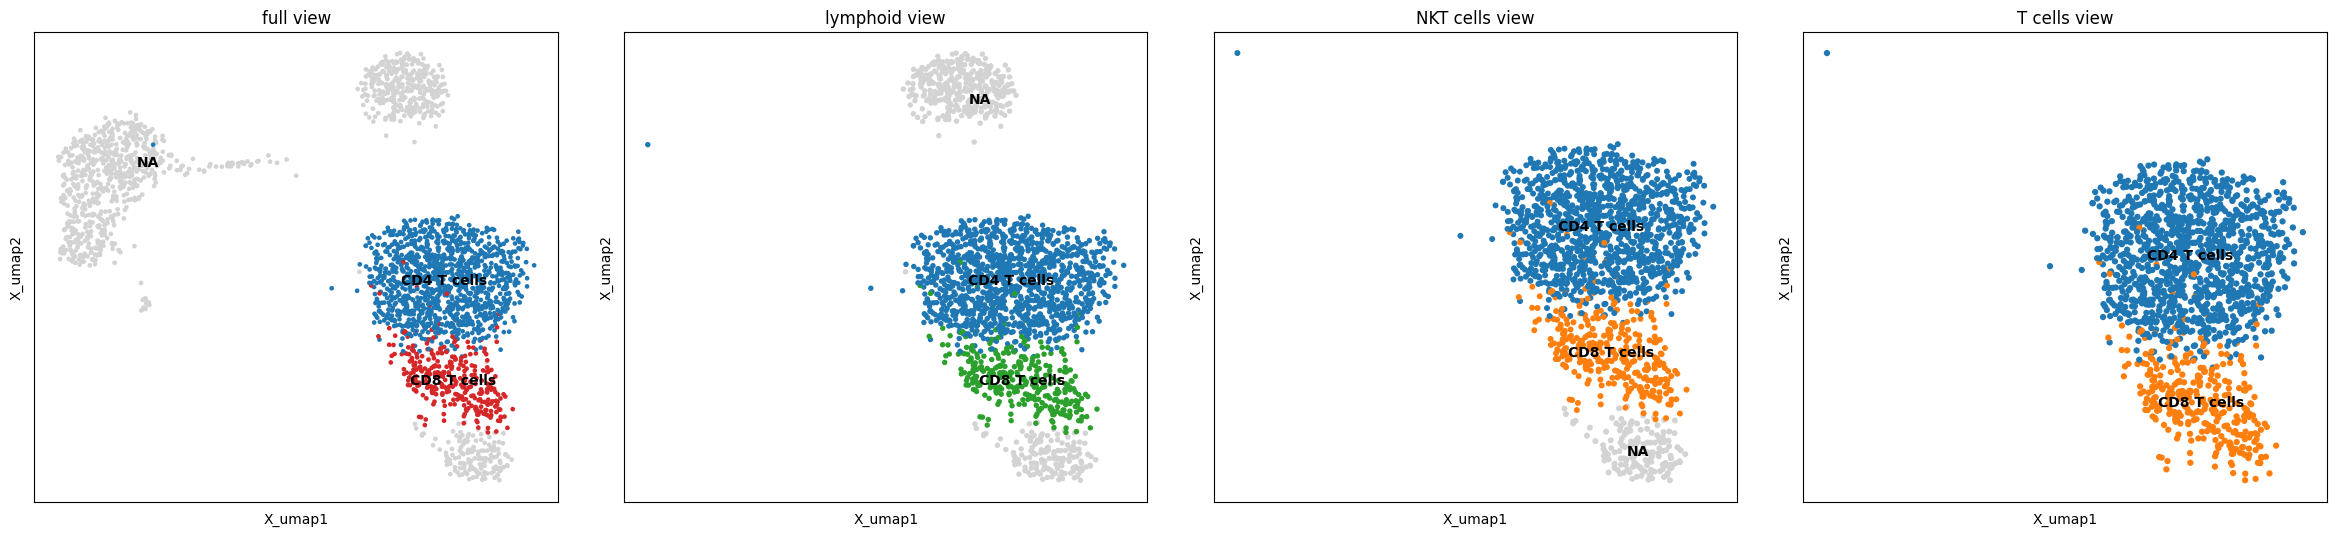

In [104]:
from multi_view_atlas.pl import multiview_embedding
multiview_embedding(mva_mapped.mdata, view='T cells', color='louvain')